In [2]:
from IPython.display import HTML
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

# Foundations of Data Mining: Assignment 1

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [3]:
# Please fill in your names here
NAME_STUDENT_1 = "Stijn Oostdam"
NAME_STUDENT_2 = "Nathan Cassee"

In [3]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "all"

## MoneyBall (5 points, 1+2+1+1)
In the early 2000s, 2 baseball scouts completely changed the game of baseball by analysing the available data about baseball players and hiring the best ones.
The [MoneyBall dataset](https://www.openml.org/d/41021) contains this data (click the link for more details). The goal is to accurately predict the number of 'runs' each player can score. 

In [29]:
moneyball = oml.datasets.get_dataset(41021) # Download MoneyBall data
# Get the predictors X and the target y
X, y, attribute_names = moneyball.get_data(target=moneyball.default_target_attribute, return_attribute_names=True)
# Describe the data with pandas, just to get an overview
ballframe = pd.DataFrame(X, columns=attribute_names)
ballframe.describe()

Team  League     Year       RA   ...    RankPlayoffs        G  \
count  1232.00  1232.0  1232.00  1232.00   ...          244.00  1232.00   
mean     15.67     0.5  1988.96   715.08   ...            1.72     3.92   
std       9.72     0.5    14.82    93.08   ...            1.10     0.62   
min       0.00     0.0  1962.00   472.00   ...            0.00     0.00   
25%       7.00     0.0  1976.75   649.75   ...            1.00     4.00   
50%      16.00     0.5  1989.00   709.00   ...            2.00     4.00   
75%      23.00     1.0  2002.00   774.25   ...            3.00     4.00   
max      38.00     1.0  2012.00  1103.00   ...            4.00     7.00   

         OOBP    OSLG  
count  420.00  420.00  
mean     0.33    0.42  
std      0.02    0.03  
min      0.29    0.35  
25%      0.32    0.40  
50%      0.33    0.42  
75%      0.34    0.44  
max      0.38    0.50  

[8 rows x 14 columns]

1 . Visually explore the data. Plot the distribution of each feature (e.g. histograms), as well as the target. Visualize the dependency of the target on each feature (use a 2d scatter plot). Is there anything that stands out? Is there something that you think might require special treatment?
- Feel free to create additional plots that help you understand the data
- Only visualize the data, you don't need to change it (yet)

Team  League     Year       RA   ...     RankPlayoffs        G  \
count  1232.00  1232.0  1232.00  1232.00   ...          1232.00  1232.00   
mean     15.67     0.5  1988.96   715.08   ...             0.34     3.92   
std       9.72     0.5    14.82    93.08   ...             0.84     0.62   
min       0.00     0.0  1962.00   472.00   ...             0.00     0.00   
25%       7.00     0.0  1976.75   649.75   ...             0.00     4.00   
50%      16.00     0.5  1989.00   709.00   ...             0.00     4.00   
75%      23.00     1.0  2002.00   774.25   ...             0.00     4.00   
max      38.00     1.0  2012.00  1103.00   ...             4.00     7.00   

           OOBP     OSLG  
count  1.23e+03  1232.00  
mean   3.32e-01     0.42  
std    8.92e-03     0.02  
min    2.94e-01     0.35  
25%    3.32e-01     0.42  
50%    3.32e-01     0.42  
75%    3.32e-01     0.42  
max    3.84e-01     0.50  

[8 rows x 14 columns]

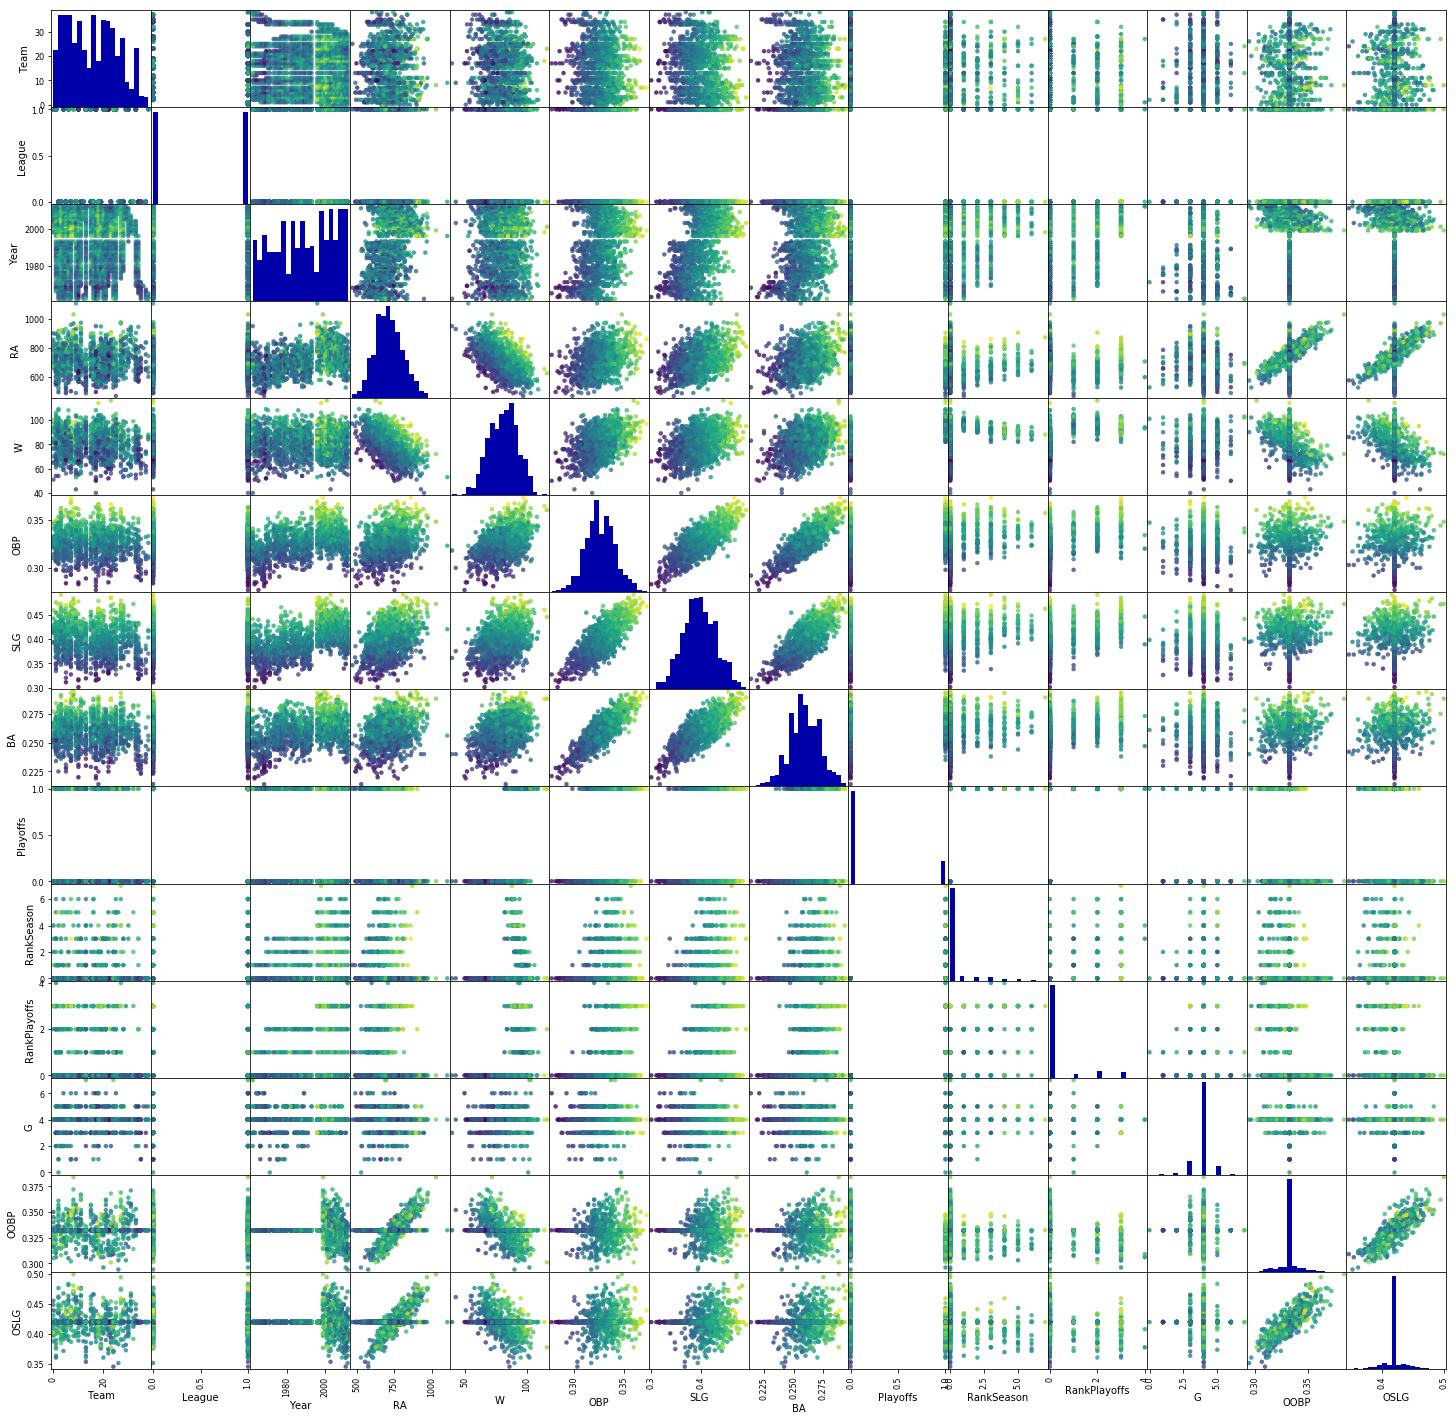

In [31]:
from sklearn.preprocessing import Imputer

ballframe.fillna(value={'Playoffs': 0, 'RankSeason': 0, 'RankPlayoffs': 0}, inplace=True)

X = ballframe.values

imputer = Imputer(strategy="mean")

impute_ballframe = pd.DataFrame(imputer.fit_transform(ballframe), columns = attribute_names)

impute_ballframe.describe()

sm = pd.scatter_matrix(impute_ballframe, c=y, figsize=(25,25), 
                  marker='o', hist_kwds={'bins': 20}, s=20, 
                  alpha=.8, cmap='viridis')

#### 1.1 Data analysis

If we take a look at the data we can see that there are Ratio and Interval features that do not require any processing. These include values such as `RA`, `W` and `OBP`. In addition to the Ratio and Interval features there are also featuers which are Categorical. Such as `RankPlayoffs` or `RankSeason`, where we assume that a higher rank in the playoffs or a higher rank in the season is a better result. 

Lastly there are also Categorical features such as `League` and `Playoffs`, which are binary features. 

2 . Compare all linear regression algorithms that we covered in class (Linear Regression, Ridge, Lasso and ElasticNet), as well as kNN. Evaluate using cross-validation and the $R^2$ score, with the default parameters. Does scaling the data with StandardScaler help? Provide a concise but meaningful interpretation of the results.
- Preprocess the data as needed (e.g. are there nominal features that are not ordinal?). If you don't know how to proceed, remove the feature and continue.

To preprocess the data we chose two approaches. For values that are missing in the ordinal features such as `Playoffs`, `RankSeason` and `RankPlayoffs` we have opted to replace `Nan` values with 0. As we assume that a higher score is better and rows without a value in these features did not reach the playoff phase. 

Finally for the columns `OOBP` and `OSLG` which also have `NaN` values we chose to use an `Imputer` to fill the value there with the mean. This is because of the fact that an absence in any of these values should not impact any of the regressions. We chose to use the mean instead of the median as there is no long tail in the distribution of both `OOBP` and `OSLG`.

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


def run_reg_comp_for_dataset(X, y, regressor, name):
    scores = cross_val_score(regressor, X, y, cv=10)
    print("Cross-validation scores {} regression: {}".format(name, scores))
    
print("Without scaler:")
run_reg_comp_for_dataset(X, y, Pipeline([("imp", Imputer(strategy='mean')), ("reg", LinearRegression())]), "linear")
run_reg_comp_for_dataset(X, y, Pipeline([("imp", Imputer(strategy='mean')), ("reg", Ridge())]), "ridge")
run_reg_comp_for_dataset(X, y, Pipeline([("imp", Imputer(strategy='mean')), ("reg", Lasso())]), "lasso")
run_reg_comp_for_dataset(X, y, Pipeline([("imp", Imputer(strategy='mean')), ("reg", ElasticNet())]), "elastic net")

run_reg_comp_for_dataset(X, y, Pipeline([("imp", Imputer(strategy='mean')), ("reg", KNeighborsRegressor(n_neighbors=12))]), "KNN")

print("With scaler:")

run_reg_comp_for_dataset(X, y, Pipeline([("imp", Imputer(strategy='mean')), ("scaler", StandardScaler()), ("reg", LinearRegression())]), "linear")
run_reg_comp_for_dataset(X, y, Pipeline([("imp", Imputer(strategy='mean')), ("scaler", StandardScaler()), ("reg", Ridge())]), "ridge")
run_reg_comp_for_dataset(X, y, Pipeline([("imp", Imputer(strategy='mean')), ("scaler", StandardScaler()), ("reg", Lasso())]), "lasso")
run_reg_comp_for_dataset(X, y, Pipeline([("imp", Imputer(strategy='mean')), ("scaler", StandardScaler()), ("reg", ElasticNet())]), "elastic net")

run_reg_comp_for_dataset(X, y, Pipeline([("imp", Imputer(strategy='mean')), ("scaler", StandardScaler()), 
                                         ("reg", KNeighborsRegressor(n_neighbors=12))]), "KNN")


Without scaler:
Cross-validation scores linear regression: [0.931 0.892 0.928 0.933 0.905 0.917 0.914 0.919 0.945 0.949]
Cross-validation scores ridge regression: [0.809 0.752 0.854 0.846 0.859 0.865 0.84  0.825 0.873 0.877]
Cross-validation scores lasso regression: [0.763 0.69  0.821 0.808 0.824 0.823 0.79  0.78  0.84  0.837]
Cross-validation scores elastic net regression: [0.762 0.689 0.82  0.807 0.825 0.824 0.79  0.779 0.841 0.838]
Cross-validation scores KNN regression: [0.359 0.561 0.568 0.425 0.706 0.657 0.649 0.508 0.546 0.582]
With scaler:
Cross-validation scores linear regression: [0.931 0.892 0.928 0.933 0.905 0.917 0.914 0.919 0.945 0.949]
Cross-validation scores ridge regression: [0.931 0.892 0.928 0.933 0.905 0.917 0.914 0.919 0.945 0.949]
Cross-validation scores lasso regression: [0.923 0.89  0.926 0.929 0.903 0.915 0.913 0.922 0.946 0.939]
Cross-validation scores elastic net regression: [0.872 0.847 0.875 0.83  0.841 0.878 0.872 0.873 0.893 0.897]
Cross-validation scores

Scaling improves the performance of all regression except for linear regression. Interestingly, with scaling the accuracy of Ridge and Linear regression is identical. This presumably is due to the fact that both methods use roughly the same formula to fit the data, as Ridge requires that the coefficients are close to zero. The scaler probably transforms the data in such way that effectively the same formula is used for both linear and ridge. 

Additionally it can be observed that the KNN regressor has some folds with which it underperforms. However, this is much less noticeable if the data is scaled. And for both lasso and elastic net scaling has a significant impact on the accuracy. 

3 . Do a default, shuffled train-test split and optimize the linear models for the degree of regularization ($alpha$) and choice of penalty (L1/L2). For Ridge and  Lasso, plot a curve showing the effect of the training and test set performance ($R^2$) while increasing the degree of regularization for different penalties. For ElasticNet, plot a heatmap $alpha \times l1\_ratio \rightarrow R^2$ using test set performance.
Report the optimal performance. Again, provide a concise but meaningful interpretation. What does the regularization do? Can you get better results?
- Think about how you get the L1/L2 loss. This is not a hyperparameter in regression.
- We've seen how to generate such heatmaps in Lecture 3.

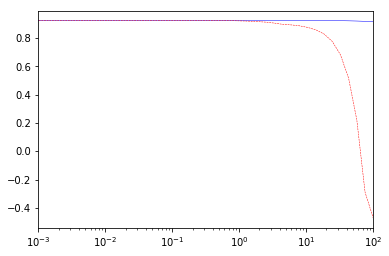

In [42]:
from sklearn.model_selection import GridSearchCV 

param_grid_alpha = {'reg__alpha': np.logspace(-4, 2, num=50)}

ridge_pipe = Pipeline([("imp", Imputer(strategy='mean')), ("scaler", StandardScaler()), ("reg", Ridge())])
lasso_pipe = Pipeline([("imp", Imputer(strategy='mean')), ("scaler", StandardScaler()), ("reg", Lasso())])

grid_search_ridge = GridSearchCV(ridge_pipe, param_grid_alpha, cv=5)
grid_search_lasso = GridSearchCV(lasso_pipe, param_grid_alpha, cv=5)

_=grid_search_ridge.fit(X, y)
_=grid_search_lasso.fit(X, y)

results_ridge = pd.DataFrame(grid_search_ridge.cv_results_)
results_lasso = pd.DataFrame(grid_search_lasso.cv_results_)

scores_ridge = np.array(results_ridge.mean_test_score)
scores_lasso = np.array(results_lasso.mean_test_score)
    
_=plt.plot(param_grid_alpha['reg__alpha'], scores_ridge, 'b')
_=plt.plot(param_grid_alpha['reg__alpha'], scores_lasso, 'r')
_=plt.xscale('log')
_=plt.xlim([0.001, 100])
plt.show()


In the above plot the effect of scaling alpha for both Ridge (red) and Alpha (blue) can be seen. For Ridge it becomes clear that as alpha is increased to a value higher than 10 it starts to overfit and accuracy decreases. Meanwhile the Lasso regressor does not suffer this problem for higher values of alpha. 

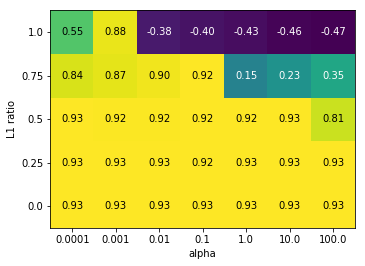

In [67]:
from sklearn.model_selection import GridSearchCV 

param_grid_elastic_net = {'reg__alpha': np.logspace(-4, 2, num=7),
              'reg__l1_ratio': np.linspace(0, 1, num=5)}

elasticNet_pipe = Pipeline([("imp", Imputer(strategy='mean')), ("scaler", StandardScaler()), ("reg", ElasticNet())])

grid_search = GridSearchCV(elasticNet_pipe, param_grid_elastic_net, cv=5)

grid_search.fit(X, y)

results = pd.DataFrame(grid_search.cv_results_)

scores = np.array(results.mean_test_score).reshape(param_grid_elastic_net['reg__l1_ratio'].size, param_grid_elastic_net['reg__alpha'].size)
# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='alpha', xticklabels=param_grid_elastic_net['reg__alpha'],
                      ylabel='L1 ratio', yticklabels=param_grid_elastic_net['reg__l1_ratio'], cmap="viridis");

Meanwhile for Elastic Net the L1 ratio has the biggest impact on the accuracy. As scaling that parameter has the most impact on the accuracy, and where more L2 regularization results in worse performance. However, for a specific value of alpha the overffiting introduced by using more L2 regularization can be compensated. As the combination of alpha = 0.001 and L1 ratio = .88 still has a relatively decent performance. 

4 . Visualize the coefficients of the optimized models. Do they agree on which features are
important? Compare the results with the feature importances returned by a RandomForest. Does it agree with the linear models? What would look for when scouting for a baseball player?

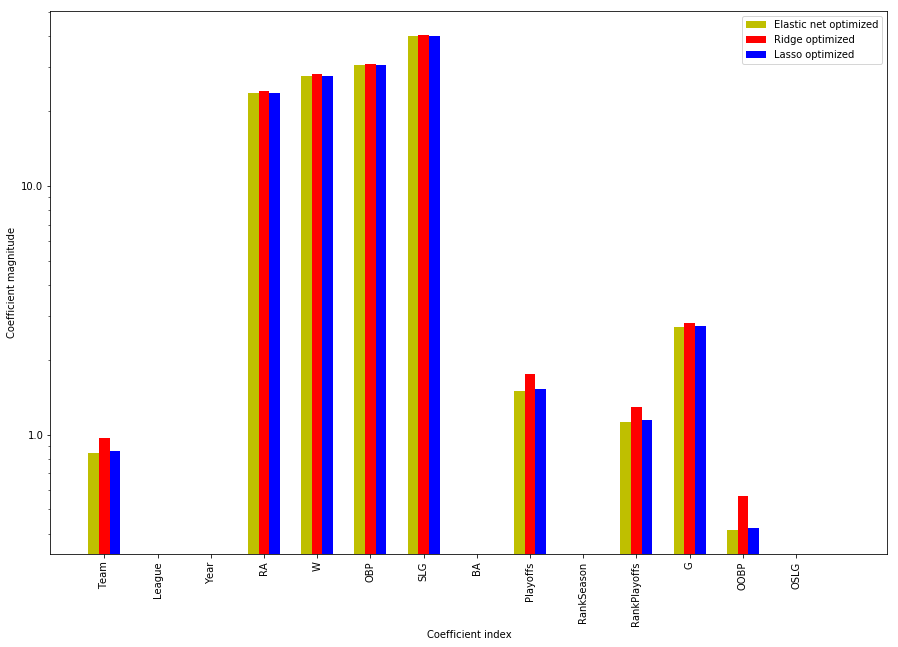

In [64]:
from matplotlib.ticker import ScalarFormatter


_=plt.figure(figsize=(15,10))

ax = plt.subplot(111)

_=ax.bar(np.linspace(0, 13, num=14)-0.2, grid_search.best_estimator_.get_params()['reg'].coef_, width=0.2,color= 'y', label="Elastic net optimized");
_=ax.bar(np.linspace(0, 13, num=14), grid_search_ridge.best_estimator_.get_params()['reg'].coef_, width=0.2,color= 'r', label="Ridge optimized")
_=ax.bar(np.linspace(0, 13, num=14)+0.2, grid_search_lasso.best_estimator_.get_params()['reg'].coef_, width=0.2,color= 'b', label="Lasso optimized")

_=plt.xlabel("Coefficient index");
_=plt.ylabel("Coefficient magnitude");
_=plt.hlines(0, 0, len(grid_search.best_estimator_.get_params()['reg'].coef_))
_=plt.yscale('log')
_=ax.yaxis.set_major_formatter(ScalarFormatter())
_=plt.xticks(range(14), attribute_names, rotation=90)
plt.legend()


The optimal models for elastic net, ridge and lasso roughly agree on the importance of features. Most importantly they all agree on features which they consider not to be important. As they all find League, Year, BA, RankSeason and OSLG not significant. Meanwhile there are small difference in which regression model considers which feature to be important. Where for instance Ridge considerse the OOBP coefficient more important than both Ridge and Lasso. 

However, as the optimal accuracy for all three regressors is roughly equal to each other it can be expected that they all use roughly equal coefficients. 

## Nepalese character recognition (5 points, 1+2+2)
The [Devnagari-Script dataset](https://www.openml.org/d/40923) contains 92,000 images (32x32 pixels) of 46 characters from Devanagari script. Your goal is to learn to recognize the right letter given the image.

In [68]:
devnagari = oml.datasets.get_dataset(40923) # Download Devnagari data
# Get the predictors X and the labels y
X, y = devnagari.get_data(target=devnagari.default_target_attribute); 
classes = devnagari.retrieve_class_labels(target_name='character') # This one takes a while, skip if not needed

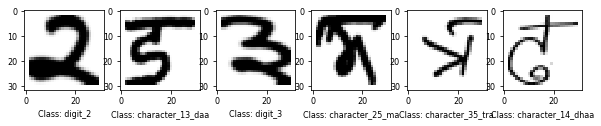

In [14]:
from random import randint
# Take some random examples, reshape to a 32x32 image and plot
fig, axes = plt.subplots(1, 6,  figsize=(10, 5))
for i in range(6):
    n = randint(0,90000)
    axes[i].imshow(X[n].reshape(32, 32), cmap=plt.cm.gray_r)
    axes[i].set_xlabel("Class: %s" % (classes[y[n]]))
plt.show();

1. Evaluate k-Nearest Neighbors, Logistic Regression and RandomForests with their default settings.
    - Take a stratified 10% subsample of the data.
    - Use the default train-test split and predictive accuracy. Is predictive accuracy a good scoring measure for this problem?
    - Try to build the same models on increasingly large samples of the dataset (e.g. 10%, 20%,...). Plot the training time and the predictive performance for each. Stop when the training time becomes prohibitively large (this will be different for different models). 

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import time

sampleSizes = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
knnScores = []
knnTimes = []
lrScores = []
lrTimes = []
rfScores = []
rfTimes = []


for size in sampleSizes:  
    X_train_stratified, X_test_stratified, y_train_stratified, y_test_stratified = train_test_split(X, y, random_state=0, train_size=size, stratify=y)
    
    X_train, X_test, y_train, y_test = train_test_split(X_train_stratified, y_train_stratified)
    
    print("starting with knn on " + str(size))
    
    #knn
    start_time = time.time()    
    knn = KNeighborsClassifier(n_jobs=-1).fit(X_train, y_train)    
    knnScores.append(knn.score(X_test, y_test))
    knnTimes.append(time.time() - start_time)
    
    print("finished knn, starting with lr on " + str(size))
    
    #lr
    start_time = time.time()    
    lr = LogisticRegression(n_jobs=-1).fit(X_train, y_train)
    lrScores.append(lr.score(X_test, y_test))
    lrTimes.append(time.time() - start_time)
    
    print("finished lr, starting with fr on " + str(size))
    
    #rf
    start_time = time.time() 
    rf = RandomForestClassifier(n_jobs=-1).fit(X_train, y_train)
    rfScores.append(rf.score(X_test, y_test))
    rfTimes.append(time.time() - start_time)
    
    print("Done with " + str(size) + ", running time: " + str(sum(knnTimes) + sum(lrTimes) + sum(rfTimes)))
    
    if sum(knnTimes) + sum(lrTimes) + sum(rfTimes) > 15*60:
        break #break after 15 minutes of running

starting with knn on 0.05
finished knn, starting with lr on 0.05
finished lr, starting with fr on 0.05
Done with 0.05, running time: 44.77685499191284
starting with knn on 0.1
finished knn, starting with lr on 0.1
finished lr, starting with fr on 0.1
Done with 0.1, running time: 267.63348364830017
starting with knn on 0.15
finished knn, starting with lr on 0.15
finished lr, starting with fr on 0.15
Done with 0.15, running time: 1494.2382354736328


Text(0.5,7,'Time')

Text(21.375,0.5,'Score')

Text(0.5,4.64,'Time')

Text(0.5,17.64,'Time')

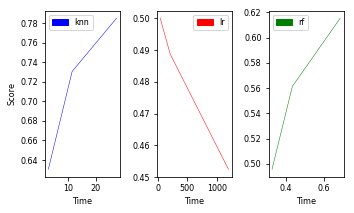

In [18]:
import matplotlib.patches as mpatches

plt.subplot(1, 3, 1)
plt.tight_layout()
knn_patch = mpatches.Patch(color='blue', label='knn')
plt.legend(handles=[knn_patch])
plt.xlabel('Time')
plt.ylabel('Score')
plt.plot(knnTimes, knnScores, 'b')

plt.subplot(1, 3, 2)
plt.tight_layout()
lr_patch = mpatches.Patch(color='red', label='lr')
plt.legend(handles=[lr_patch])
plt.xlabel('Time')
plt.plot(lrTimes, lrScores, 'r')

plt.subplot(1, 3, 3)
plt.tight_layout()
rf_patch = mpatches.Patch(color='green', label='rf')
plt.legend(handles=[rf_patch])
plt.xlabel('Time')
plt.plot(rfTimes, rfScores, 'g')
plt.show()

**Is predictive accuracy a good scoring measure for this problem?**

Yes, ultimately you want to have a model which predicts as best as possible. With the above plots it is possible to make a trade off between running time and the predictive accuracy.

2 . Optimize the value for the number of neighbors $k$ (keep $k$ < 50) and the number of trees (keep $n\_estimators$ < 100) on the stratified 10% subsample.
- Use 10-fold crossvalidation and plot $k$ and $n\_estimators$ against the predictive accuracy. Which value of $k$, $n\_estimators$ should you pick?

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

X_train_stratified, X_test_stratified, y_train_stratified, y_test_stratified = train_test_split(X, y, random_state=0, train_size=0.1, stratify=y)

knn_grid_search = GridSearchCV(KNeighborsClassifier(n_jobs=-1), {'n_neighbors': [1,5,10,15,20,25,30,35,40,45,50]}, cv=10)
rf_grid_search = GridSearchCV(RandomForestClassifier(n_jobs=-1), {'n_estimators':  [1,10,20,30,40,50,60,70,80,90,100]}, cv=10)

knn_grid_search.fit(X_train_stratified, y_train_stratified)
rf_grid_search.fit(X_train_stratified, y_train_stratified)

print("Best parameter for knn (this is the value you should pick): {}".format(knn_grid_search.best_params_))
print("Best cross-validation score for knn: {:.2f}".format(knn_grid_search.best_score_))
print("Best parameter for rf (this is the value you should pick): {}".format(rf_grid_search.best_params_))
print("Best cross-validation score for rf: {:.2f}".format(rf_grid_search.best_score_))

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best parameter for knn (this is the value you should pick): {'n_neighbors': 1}
Best cross-validation score for knn: 0.79
Best parameter for rf (this is the value you should pick): {'n_estimators': 100}
Best cross-validation score for rf: 0.78


3 . For the RandomForest, optimize both $n\_estimators$ and $max\_features$ at the same time on the entire dataset.
- Use a nested cross-validation and a random search over the possible values, and measure the accuracy. Explore how fine-grained this random search can be, given your computational resources. What is the optimal performance you find?
- Hint: choose a nested cross-validation that is feasible. Don't use too many folds in the outer loop.
- Repeat the grid search and visualize the results as a plot (heatmap) $n\_estimators \times max\_features \rightarrow ACC$ with ACC visualized as the color of the data point. Try to make the grid as fine as possible. Interpret the results. Can you explain your observations? What did you learn about tuning RandomForests?

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

X_train_stratified, X_test_stratified, y_train_stratified, y_test_stratified = train_test_split(X, y, random_state=0, train_size=0.1, stratify=y)

param_grid = {'n_estimators': [10,20,30,40,50,60,70,80], 'max_features': [1,2,3,4,5,6,7,8]}

rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1), param_grid=param_grid, cv=5)
rf_grid_search.fit(X_train_stratified, y_train_stratified)

nested_score = cross_val_score(rf_grid_search, X=X_train_stratified, y=y_train_stratified, cv=2).mean()

print("Best grid search score: ", rf_grid_search.best_score_)
print("Cross validation score: ", nested_score)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7, 8], 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best grid search score:  0.7563043478260869
Cross validation score:  0.7035869565217392


**Use a nested cross-validation and a random search over the possible values, and measure the accuracy. Explore how fine-grained this random search can be, given your computational resources. What is the optimal performance you find?**

As can be seen above, the best score was 0.70. We limited the parameter grid to 8x8 = 64 combinations given our computational resources.

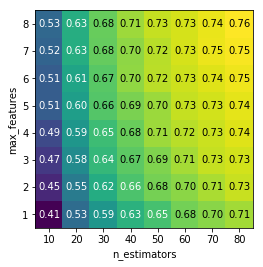

In [70]:
results = pd.DataFrame(rf_grid_search.cv_results_)

scores = np.array(results.mean_test_score).reshape(len(param_grid['max_features']), len(param_grid['n_estimators']))

mglearn.tools.heatmap(scores, xlabel='n_estimators', xticklabels=param_grid['n_estimators'],
                      ylabel='max_features', yticklabels=param_grid['max_features'], cmap="viridis")

**Interpret the results. Can you explain your observations? What did you learn about tuning RandomForests?**
 
From the results visible in the heatmap, it seems that it keeps performing better when it has more estimators. The same is the case for the maximum number of features. The best score is achieved (0.76) when both parameters are at their highest.

## 3. Understanding Ensembles (5 points (3+2))
Do a deeper analysis of how RandomForests and Gradient Boosting reduce their prediction error. We'll use the MAGIC telescope dataset (http://www.openml.org/d/1120). When high-energy particles hit the atmosphere, they produce chain reactions of other particles called 'showers', and you need to detect whether these are caused by gamma rays or cosmic rays.

In [4]:
# Get the data
magic_data = oml.datasets.get_dataset(1120) # Download MAGIC Telescope data
X, y = magic_data.get_data(target=magic_data.default_target_attribute);

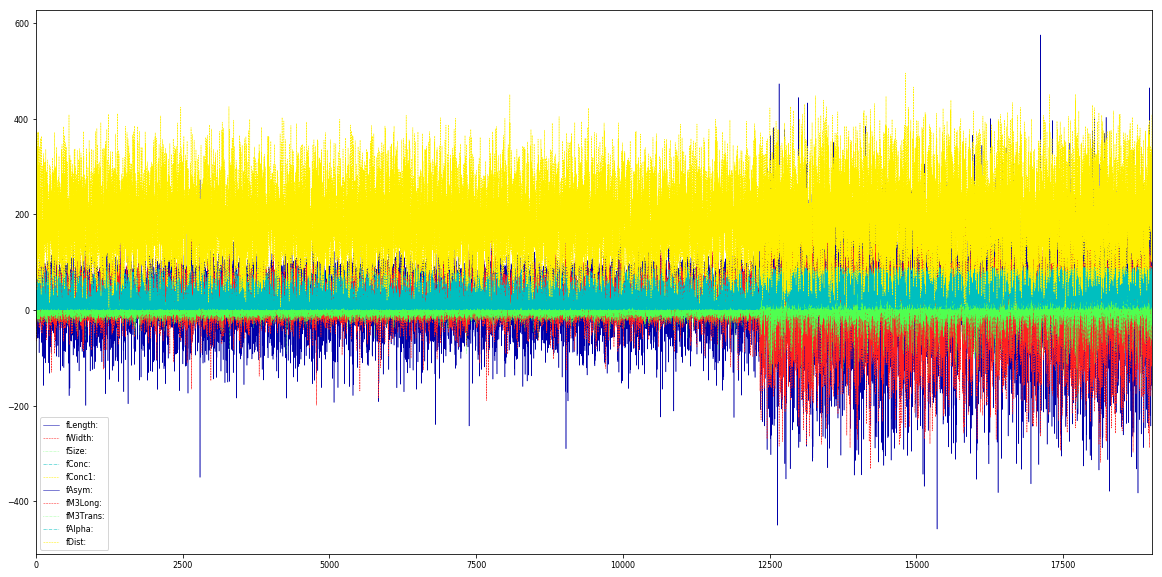

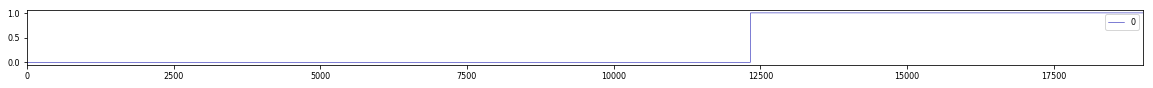

In [8]:
# Quick visualization
X, y, attribute_names = magic_data.get_data(target=magic_data.default_target_attribute, return_attribute_names=True)
magic = pd.DataFrame(X, columns=attribute_names)
magic.plot(figsize=(20,10))
# Also plot the target: 1 = gamma, 0 = background
pd.DataFrame(y).plot(figsize=(20,1));

1 . Do a bias-variance analysis of both algorithms. For each, vary the number of trees on a log scale from 1 to 1024, and plot the bias error (squared), variance, and total error (in one plot per algorithm). Interpret the results. Which error is highest for small ensembles, and which reduced most by each algorithm as you use a larger ensemble? When are both algorithms under- or overfitting? Provide a detailed explanation of why random forests and gradient boosting behave this way.
- See lecture 3 for an example on how to do the bias-variance decomposition
- To save time, you can use a 10% stratified subsample in your initial experiments, but show the plots for the full dataset in your report.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import train_test_split, ShuffleSplit

rf_biases = []
rf_variances = []
rf_errors = []

gb_biases = []
gb_variances = []
gb_errors = []

n_repeat = 100

logs = np.logspace(0, 10, num=11, base=2).astype(np.int64)

for n_trees in logs:
    gb = GradientBoostingClassifier(n_estimators=n_trees)
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=0, n_jobs=-1)
    
    shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat)

    # Store sample predictions
    gb_y_all_pred = [[] for _ in range(len(y))]
    rf_y_all_pred = [[] for _ in range(len(y))]

    # Train classifier on each bootstrap and score predictions
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        fit = gb.fit(X[train_index], y[train_index])
        gb_y_pred = gb.predict(X[test_index])
        
        # Train and predict
        fit = rf.fit(X[train_index], y[train_index])
        rf_y_pred = rf.predict(X[test_index])

        # Store predictions
        for i, index in enumerate(test_index):
            gb_y_all_pred[index].append(gb_y_pred[i])
            rf_y_all_pred[index].append(rf_y_pred[i])

    # Compute bias, variance, error for GD
    gb_bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
                for i,x in enumerate(gb_y_all_pred)])
    gb_var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
               for i,x in enumerate(gb_y_all_pred)])
    gb_error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
            for i,x in enumerate(gb_y_all_pred)])
    
    print("GradientBoosting, number of trees %d: Bias squared: %.2f, Variance: %.2f, Total error: %.2f" % (n_trees, gb_bias_sq, gb_var, gb_error))
    gb_biases.append(gb_bias_sq)
    gb_variances.append(gb_var)
    gb_errors.append(gb_error)
    
    # Compute bias, variance, error for RF
    rf_bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
                for i,x in enumerate(rf_y_all_pred)])
    rf_var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
               for i,x in enumerate(rf_y_all_pred)])
    rf_error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
            for i,x in enumerate(rf_y_all_pred)])
    
    print("RandomForest, number of trees %d: Bias squared: %.2f, Variance: %.2f, Total error: %.2f" % (n_trees, rf_bias_sq, rf_var, rf_error))
    rf_biases.append(rf_bias_sq)
    rf_variances.append(rf_var)
    rf_errors.append(rf_error)

GradientBoosting, number of trees 1: Bias squared: 2211.63, Variance: 0.00, Total error: 2211.63
RandomForest, number of trees 1: Bias squared: 584.71, Variance: 666.67, Total error: 1251.38
GradientBoosting, number of trees 2: Bias squared: 2212.43, Variance: 0.00, Total error: 2212.43
RandomForest, number of trees 2: Bias squared: 691.48, Variance: 426.46, Total error: 1117.94
GradientBoosting, number of trees 4: Bias squared: 1352.40, Variance: 65.36, Total error: 1417.76
RandomForest, number of trees 4: Bias squared: 623.95, Variance: 329.28, Total error: 953.23
GradientBoosting, number of trees 8: Bias squared: 1174.43, Variance: 67.15, Total error: 1241.58
RandomForest, number of trees 8: Bias squared: 606.21, Variance: 245.56, Total error: 851.77
GradientBoosting, number of trees 16: Bias squared: 973.61, Variance: 75.91, Total error: 1049.52
RandomForest, number of trees 16: Bias squared: 619.50, Variance: 184.56, Total error: 804.06
GradientBoosting, number of trees 32: Bias s

Text(0.5,7,'n_estimates')

Text(0.5,1,'RandomForest')

Text(0.5,4.64,'n_estimates')

Text(0.5,1,'GradientBoosting')

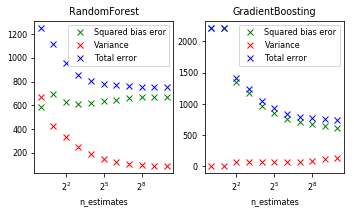

In [10]:
plt.subplot(1, 2, 1)
plt.tight_layout()
plt.plot(logs, rf_biases, 'gx', label = "Squared bias eror")
plt.plot(logs, rf_variances, 'rx', label = "Variance")
plt.plot(logs, rf_errors, 'bx', label = "Total error")
plt.xlabel('n_estimates')
plt.xscale('log',basex=2)
plt.legend()
plt.title('RandomForest')

plt.subplot(1, 2, 2)
plt.tight_layout()
plt.plot(logs, gb_biases, 'gx', label = "Squared bias eror")
plt.plot(logs, gb_variances, 'rx', label = "Variance")
plt.plot(logs, gb_errors, 'bx', label = "Total error")
plt.xlabel('n_estimates')
plt.xscale('log',basex=2)
plt.legend()
plt.title('GradientBoosting')
plt.show()

**Which error is highest for small ensembles, and which reduced most by each algorithm as you use a larger ensemble? When are both algorithms under- or overfitting? Provide a detailed explanation of why random forests and gradient boosting behave this way.**

As can be seen, for both RandomForest and GradientBoosting, the total error is the highest for small ensembles. However, the bias error is high for GradientBoosting as well (since the variance is low). For RandomForest, the variance decreases the most when using larger ensembles. For GradientBoosting, this is the bias error (total error decreases a lot as well since a large part of the total error for GradientBoosting is the bias error). 

High variance is linked to overfitting and high bias is linked to underfitting.
Our plots show that RandomForest starts with overfitting which decreases when increasing the ensembles, however a larger ensemble does not help RandomForest with its relatively high bias error, which means that it keeps underfitting.

From the start, GradientBoosting performs highly with respect to overfitting, but it does increase a little bit with larger ensembles. GradientBoosting does have a lot of underfitting with small ensembles, which decreases when using larger ensembles.

OVerall, RandomForest performs better when having medium sized ensembles, but after that, GradientBoosting is btter due to its low variance.

2 . A _validation curve_ can help you understand when a model starts under- or overfitting. It plots both training and test set error as you change certain characteristics of your model, e.g. one or more hyperparameters. Build validation curves for gradient boosting, evaluated using AUROC, by varying the number of iterations between 1 and 500. In addition, use at least two values for the learning rate (e.g. 0.1 and 1), and tree depth (e.g. 1 and 4). This will yield at least 4 curves. Interpret the results and provide a clear explanation for the results. When is the model over- or underfitting? Discuss the effect of the different combinations learning rate and tree depth and provide a clear explanation.
- While scikit-learn has a `validation_curve` function, we'll use a modified version (below) that provides a lot more detail and can be used to study more than one hyperparameter. You can use a default train-test split.

In [5]:
# Plots validation curves for every classifier in clfs. 
# Also indicates the optimal result by a vertical line
# Uses 1-AUROC, so lower is better
def validation_curve(clfs, X_test, y_test, X_train, y_train):
    for n,clf in enumerate(clfs):
        test_score = np.empty(len(clf.estimators_))
        train_score = np.empty(len(clf.estimators_))

        for i, pred in enumerate(clf.staged_decision_function(X_test)):
            test_score[i] = 1-roc_auc_score(y_test, pred)

        for i, pred in enumerate(clf.staged_decision_function(X_train)):
            train_score[i] = 1-roc_auc_score(y_train, pred)

        best_iter = np.argmin(test_score)
        learn = clf.get_params()['learning_rate']
        depth = clf.get_params()['max_depth']
        test_line = plt.plot(test_score,
                             label='learn=%.1f depth=%i (%.2f)'%(learn,depth,
                                                                 test_score[best_iter]))

        colour = test_line[-1].get_color()
        plt.plot(train_score, '--', color=colour)
        
        plt.xlabel("Number of boosting iterations")
        plt.ylabel("1 - area under ROC")
        plt.axvline(x=best_iter, color=colour)
        
    plt.legend(loc='best')

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

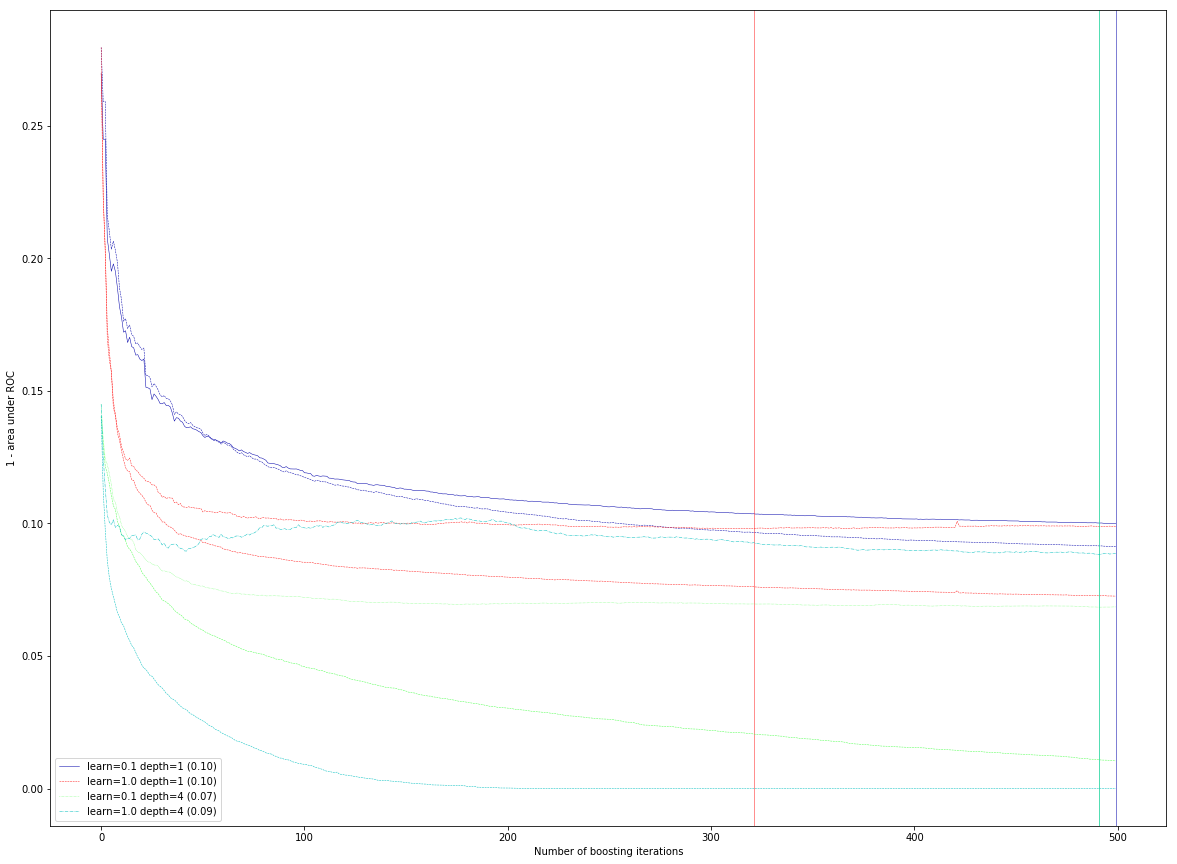

In [8]:
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

gbs = []

for depth in [1, 4]:
    for learn in [0.1, 1]:
        gb = GradientBoostingClassifier(n_estimators=500, max_depth=depth, learning_rate=learn)
        gb.fit(X_train, y_train)
        gbs.append(gb)
            
plt.figure(figsize=(20,15))
validation_curve(gbs, X_test, y_test, X_train, y_train)

**Interpret the results and provide a clear explanation for the results. When is the model over- or underfitting? Discuss the effect of the different combinations learning rate and tree depth and provide a clear explanation.**

As can be seen in the plot, it seems that a higher depth comes at the cost of overfitting. Both the lines where depth is 4 have an excellent score on the training data, but do not outperform the other two lines when it comes to the test data. This means these two are overfitting.

A lower learning rate seems to perform better when having a very high number of boosting iterations, both the lines where the learning rate is 0.1 perform better on the test data at 500 boosting iterations.

In general, a higher number of boosting iterations increases the performance of all 4 instances, which is as expected.